***Learning Rectangles***

In this post, we explore a basic computational learning problem; learning rectangles from data. Exploring this problem and the proposed solution provides a first look into the tradeoffs between data, accuracy and confidence.

This post also pairs a theorerical and exprimental exploration of the problem. By pairing theoretical work with visualizations and the instructions (code) for generating data and calculating experimental quantities, we hope to gain a deeper understanding of the tradeoffs in the rectangle learning problem and of the flavor of algorithmic proofs with probabilistic error gaurantees.

***Python Setup***

We begin by importing some modules and defining some helper functions.

In [176]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
fig = plt.figure()
def setup_fig(fig):
    axes = fig.add_subplot(111)
    axes.set_xlim([0, 10])
    axes.set_ylim([0, 10])
    return axes

def reset_fig(fig):
    fig.clear()

# class Point:
#     def __init__(self, x, y):
#         self.x = x
#         self.y = y
    
class Rectangle:
    def __init__(self, min_x, min_y, max_x, max_y):
        #  self.lower_left = Point(min_x, min_y)
        #  self.upper_right = Point(max_x, max_y)
        self.min_x = min_x
        self.max_x = max_x
        self.min_y = min_y
        self.max_y = max_y
        self.width = max_x - min_x
        self.height = max_y - min_y
    
    def contains(self, x, y):
        return self.min_x < x < self.max_x and self.min_y < y < self.max_y
    
    def area(self):
        return self.width * self.height

**Problem Setup**

Consider a distribution **D** that returns two dimensional points from coordinates within a length-10 square. For now, lets assume this distribution is uniform over the sample space. We draw **m** samples from this space.

In [177]:
m = 50
x, y = np.random.uniform(0, 10, m), np.random.uniform(0, 10, m)

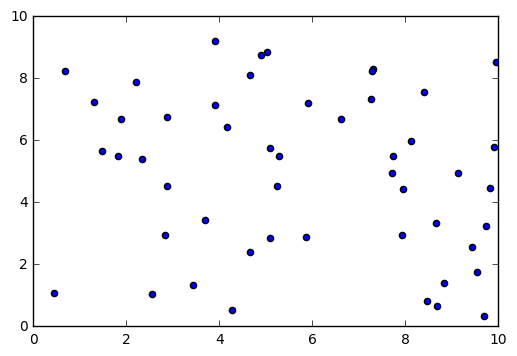

In [178]:
reset_fig(fig)
axes = setup_fig(fig)

plt.scatter(x, y)
fig

Now let's assume that there is rectanle **R** that exists in this coordinate space. Further, all points generated by the distribution **D** are are classified as positive if they exist in the interior of the rectangle, and classified as negative otherwise.

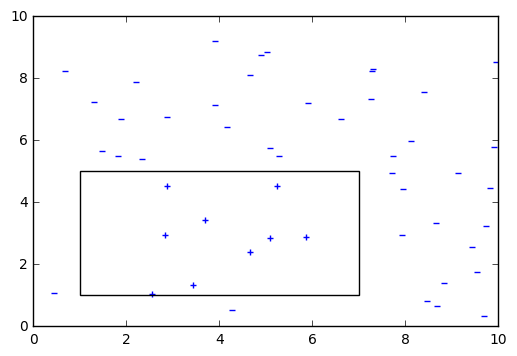

In [179]:
reset_fig(fig)
axes = setup_fig(fig)

# Determine Rectangle

x_corner, y_corner = 1, 1
width, height = 6, 4

R = Rectangle(x_corner, y_corner, x_corner + width, y_corner + height)

# Classify Points

pos_x, pos_y = zip(*[(x, y) for x, y in zip(x, y) if R.contains(x, y)])
neg_x, neg_y = zip(*[(x, y) for x, y in zip(x, y) if not R.contains(x, y)])

# Plot

def add_rect(axes, R, fill=False, alpha=None, no_border=False):
    border = "none" if no_border else None
    axes.add_patch(
        patches.Rectangle(
            (R.min_x, R.min_y),
            R.width,
            R.height,
            fill=fill,      # remove background
            alpha=alpha,
            edgecolor=border,
        )
    )
    return

plt.scatter(pos_x, pos_y, marker='+')
plt.scatter(neg_x, neg_y, marker='_')
add_rect(axes, R)
fig

***Goal***

Our goal is to produce a hypothesis for the rectangle **R**, and to understand the relationship between the sample size, the probability of misclassifying future points under the distribution **D**, and our confidence in our hypothesis.

**Proposed Solution**

An algorithm for learning an approximation of the rectangle **R**:
- Sample m points from distribution **D** (each point comes with a classification label).
- Choose the rectangle **R'** that most "tightly" encloses all positive samples. 
    - We can choose this rectangle in time O(m)

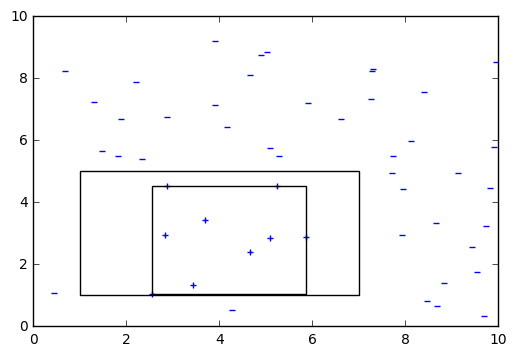

In [180]:
R_prime = Rectangle(min(pos_x), min(pos_y), max(pos_x), max(pos_y))
add_rect(axes, R_prime)
fig

We will define the error of the hypothesis rectangle **R'** produced by this algorithm as follows:

Pr_(x \in D)[h(x) != c(x)]

This only place where **R** and **R'** differ is the space inside **R** that is not covered by **R'**

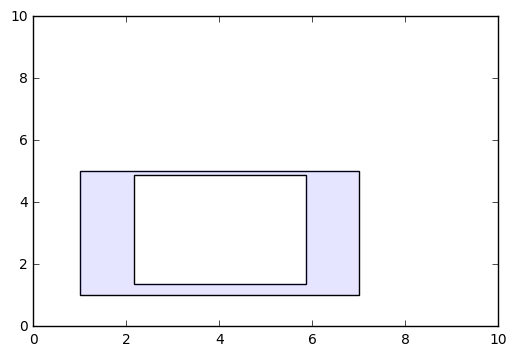

In [131]:
diff_fig = plt.figure()
diff_axes = setup_fig(diff_fig)

add_rect(diff_axes, R)
add_rect(diff_axes, R_prime)

# Build Rectangle Strips
top_strip = Rectangle(R.min_x, R_prime.max_y, R.max_x, R.max_y)
bottom_strip = Rectangle(R.min_x, R.min_y, R.max_x, R_prime.min_y)
left_strip = Rectangle(R.min_x, R.min_y, R_prime.min_x, R.max_y)
right_strip = Rectangle(R_prime.max_x, R.min_y, R.max_x, R.max_y)

# Build left and right strips for actual plotting
shaved_left_strip = Rectangle(R.min_x, R_prime.min_y, R_prime.min_x, R_prime.max_y)
shaved_right_strip = Rectangle(R_prime.max_x, R_prime.min_y, R.max_x, R_prime.max_y)

# Add strips to plot
for strip in [top_strip, bottom_strip, shaved_left_strip, shaved_right_strip]:
    add_rect(diff_axes, strip, fill=True, no_border=True, alpha=0.1)

diff_fig

It is important to note that the error is really the "weight" of this shaded area (**R** - **R'**) with respect to the probability distribution D. We know that this distribution is uniform over the 10x10 input space and can simply calculate the error rate of the given hypthesis with the ratio:

|**R** - **R'**| / |**X**|

Where **X** is the input space.

In [174]:
ratio = (R.area() - R_prime.area()) / (100.0)
print("Analytic error based on ratio: %.3f%s" % (ratio, "%"))

Analytic error based on ratio: 0.110%


For any general distribution, we can calculate this error experimentally:

In [175]:
M = 512
x_test, y_test = np.random.uniform(0, 10, M), np.random.uniform(0, 10, M)
mislabeled_examples = [(x, y) for x, y in zip(x_test, y_test) if R.contains(x, y) and not R_prime.contains(x, y)]
emperical_error = len(mislabeled_examples) / M
print("Trial with %d samples" % M)
print("Experimental error based on trials: %.3f%s" % (emperical_error, "%"))

Trial with 512 samples
Experimental error based on trials: 0.131%


We would like to prove that, for a given number of samples **m**, the error under this distribution **D** will be less than some **\epsilon** < 1/2.

NOTE TO SELF:
It is important to remember that
- Once a hypothesis is chosen, \epsilon is fixed and has nothing to do with a particular sample (except that hypothesis was chosen based on examples). But technically, the error is a function of a hypothesis, independent of the sample. E.i. a function that computes the error would not take in the samples as input.
- \delta is the probability that the hypothesis, chosen by the algorithm based samples from the distribution, will be a good hypothesis, given the distribution. While this is based on the distribution D, it may also be interesting/helpful to think as \delta as based on the distrbution of _samples_ of D. To calculate: take the set of possible samples and add up the probabilities of the samples which produce error less than \epsilon.